In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from skimage import io
from skimage.filters import gaussian

import time
import numpy as np
import hyperspy.api as hs
import matplotlib.pyplot as plt
from IPython import display

In [85]:
class CVAE3D(nn.Module):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim, size):
        super(CVAE3D, self).__init__()
        self.latent_dim = latent_dim
        self.size = size
        reduced_size = int(size/8)
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv3d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * reduced_size * reduced_size * reduced_size, latent_dim * 2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, reduced_size * reduced_size * reduced_size * 32),
            nn.ReLU(),
            nn.Unflatten(1, (32, reduced_size, reduced_size, reduced_size)),
            nn.ConvTranspose3d(32, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 1, kernel_size=3, stride=1, padding=1)
        )

    def encode(self, x):
        h = self.encoder(x)
        mean, logvar = torch.chunk(h, 2, dim=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = torch.sigmoid(logits)
            return probs
        return logits

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z)
       
############################################################################################################
##################################### END OF MODEL DEFINITION ##############################################
############################################################################################################

def load_dm4_data(filepath):
    s = hs.load(filepath)
    data = s.data  # The 3D data array
    return data

def preprocess_3d_images(images, size, sigma):
    # Check if input is a single 3D image and convert it to a batch
    if images.ndim == 3:
        images = np.expand_dims(images, axis=0)
    
    # Apply Gaussian blur to each 3D image
    blurred_images = np.array([gaussian(img, sigma=sigma) for img in images])
    
    # Normalize the images
    normalized_images = blurred_images / np.max(blurred_images)
    
    reshaped_images = []
    for img in normalized_images:
        # Calculate the padding for each dimension
        padding = [(max(0, size - dim_size) // 2, max(0, size - dim_size) - max(0, size - dim_size) // 2) for dim_size in img.shape]
        
        # Apply padding
        padded_img = np.pad(img, padding, mode='constant')
        
        # Calculate the crop for each dimension
        crop = [(max(0, padded_img.shape[i] - size) // 2, max(0, padded_img.shape[i] - size) - max(0, padded_img.shape[i] - size) // 2) for i in range(len(padded_img.shape))]
        cropped_img = padded_img[crop[0][0]:padded_img.shape[0]-crop[0][1],
                                 crop[1][0]:padded_img.shape[1]-crop[1][1],
                                 crop[2][0]:padded_img.shape[2]-crop[2][1]]
        
        # Ensure the final shape matches the target size
        assert cropped_img.shape == (size, size, size), f"Shape mismatch: {cropped_img.shape} != {(size, size, size)}"
        
        # Append the reshaped image
        reshaped_images.append(cropped_img)
    
    reshaped_images = np.array(reshaped_images)
    
    # Reshape to (N, 1, size, size, size) for PyTorch
    reshaped_images = reshaped_images.reshape((reshaped_images.shape[0], 1, size, size, size))
    
    return reshaped_images.astype('float32')


############################################################################################################
##################################### END OF DATA PREPROCESSING ############################################
############################################################################################################

def generate_images(model, epoch, test_sample):
    model.eval()
    with torch.no_grad():
        mean, logvar = model.encode(test_sample)
        z = model.reparameterize(mean, logvar)
        predictions = model.decode(z, apply_sigmoid=True)

    num_images = predictions.shape[0]
    num_rows = int(np.ceil(np.sqrt(num_images)))
    num_cols = int(np.ceil(num_images / num_rows))

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5, 5))
    if num_rows * num_cols == 1:
        axs = np.array([axs])
    else:
        axs = axs.flatten()
    for i, ax in enumerate(axs):
        if i >= predictions.shape[0]:
            ax.axis('off')
            continue
        # Visualize the middle slice of the 3D prediction
        middle_slice = predictions[i, 0, :, :, predictions.shape[2] // 2].cpu().numpy()
        ax.imshow(middle_slice, cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5, 5))
    if num_rows * num_cols == 1:
        axs = np.array([axs])
    else:
        axs = axs.flatten()
    for i, ax in enumerate(axs):
        if i >= test_sample.shape[0]:
            ax.axis('off')
            continue
        # Visualize the middle slice of the 3D input sample
        middle_slice = test_sample[i, 0, :, :, test_sample.shape[2] // 2].cpu().numpy()
        ax.imshow(middle_slice, cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = F.binary_cross_entropy_with_logits(x_logit, x, reduction='sum')
    logpx_z = -cross_ent
    logpz = log_normal_pdf(z, torch.zeros_like(z), torch.zeros_like(z))
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -torch.mean(logpx_z + logpz - logqz_x)

def log_normal_pdf(sample, mean, logvar):
    log2pi = torch.log(torch.tensor(2. * np.pi))
    return torch.sum(-0.5 * ((sample - mean) ** 2 * torch.exp(-logvar) + logvar + log2pi), dim=1)

def train_step(model, x, optimizer):
    model.train()
    optimizer.zero_grad()
    loss = compute_loss(model, x)
    loss.backward()
    optimizer.step()
    return loss.item()

def predict(model, inp_image, apply_sigmoid=True):
    model.eval()
    with torch.no_grad():
        mean, logvar = model.encode(inp_image)
        z = model.reparameterize(mean, logvar)
        predictions = model.decode(z, apply_sigmoid)
    return predictions[0, 0, :, :, predictions.shape[2] // 2].cpu().numpy()

def get_testing_training_sets(image, size=64, n_images=10):
    training = []
    testing = []
    img = io.imread(image)
    width = len(img[0])
    height = len(img)
    try:
        img = img[:, :, 0]
    except:
        pass
    for i in range(n_images):
        shift_y = np.random.randint(height // 2, height - size)
        shift_x = np.random.randint(0, width - size)
        training.append(img[shift_y:shift_y + size, shift_x:shift_x + size])
        shift_y = np.random.randint(0, height // 2 - size)
        shift_x = np.random.randint(0, width - size)
        testing.append(img[shift_y:shift_y + size, shift_x:shift_x + size])
    return np.array(training), np.array(testing)

def gaussian_blur(img, sigma):
    return np.array(gaussian(img, (sigma, sigma)))

def gaussian_blur_arr(images, sigma):
    return np.array([gaussian_blur(img, sigma) for img in images])

def norm_max_pixel(images):
    return np.array([img / np.max(img) for img in images])

def preprocess_images(images, size, sigma):
    images = gaussian_blur_arr(images, sigma)
    images = norm_max_pixel(images)
    images = images.reshape((images.shape[0], 1, size, size))
    return images.astype('float32')

In [86]:
SIZE = 48
SIGMA = 2
epochs = 400
latent_dim = 20
dm4_file = 'data/images_3D/EELS HL SI.dm4'
path = ""

# Load the data with the specified energy range and resolution
data = load_dm4_data(dm4_file)

# Specify the energy range and resolution
energy_range = (500, 600)  # eV
ev_per_pixel = 0.05

# Calculate the pixel indices corresponding to the energy range
start_pixel = int((energy_range[0] - 0))
end_pixel = int((energy_range[1] - 0))

# Slice the data array to keep only the desired energy range in the third dimension
data = data[:, :, start_pixel:end_pixel]

# show the shape of the data 
print(data.shape)


(51, 50, 100)


In [87]:
train_images = preprocess_3d_images(data, size=SIZE, sigma=SIGMA)

# Create data loaders
train_dataset = TensorDataset(torch.tensor(train_images))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Instantiate model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CVAE3D(latent_dim, SIZE).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Pick a sample of the test set for generating output images
num_examples_to_generate = 1
test_sample = next(iter(train_loader))[0][:num_examples_to_generate].to(device)


Epoch: 193, Test set ELBO: 65972.9844, time elapsed for current epoch: 0.20s


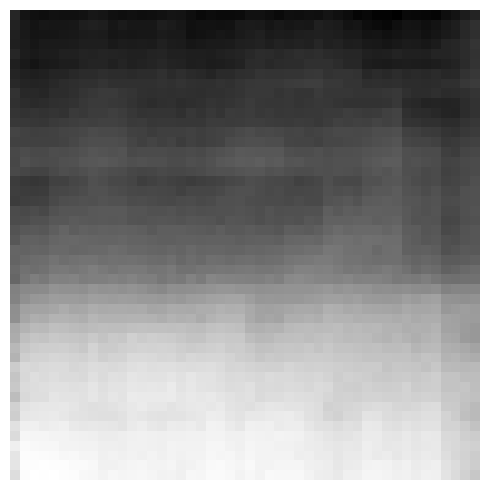

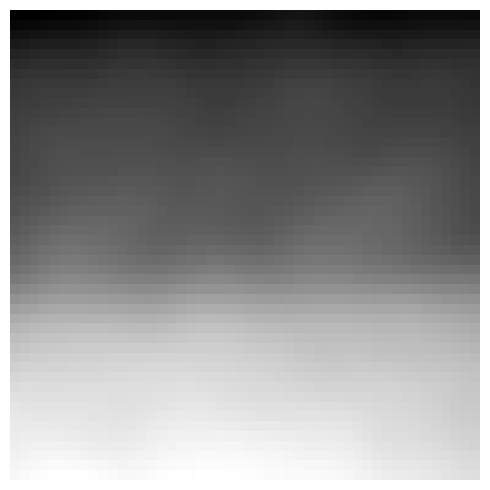

Training interrupted. Saving the model...


In [88]:
# Generate initial images
generate_images(model, 0, test_sample)

# Training loop
try: 
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        model.train()
        for batch in train_loader:
            train_x = batch[0].to(device)
            loss = compute_loss(model, train_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        end_time = time.time()

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch in train_loader:
                test_x = batch[0].to(device)
                test_loss += compute_loss(model, test_x).item()
        test_loss /= len(train_loader.dataset)
    
        display.clear_output(wait=False)
        print(f'Epoch: {epoch}, Test set ELBO: {test_loss:.4f}, time elapsed for current epoch: {end_time - start_time:.2f}s')
        generate_images(model, epoch, test_sample)
        
except KeyboardInterrupt:
    print("Training interrupted. Saving the model...")


In [ ]:
torch.save(model.state_dict(), path + 'cvae3d.pth')